In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import os
from torchvision import datasets, transforms

num_data_points = 1

class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 14 * 14, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

benign_model_path = './model/benign_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

benign_model = SimpleCNN().to(device)
benign_model.load_state_dict(torch.load(benign_model_path, map_location=device))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=len(mnist_dataset), shuffle=False)

all_data = next(iter(mnist_loader))
mnist_X, mnist_y = all_data[0].to(device), all_data[1].to(device)

selected_indices = torch.randperm(len(mnist_X))[:num_data_points]
selected_X = mnist_X[selected_indices]
selected_y = mnist_y[selected_indices]

image_folder = './image'
os.makedirs(image_folder, exist_ok=True)

for i, img_tensor in enumerate(selected_X):
    img = to_pil_image((img_tensor * 0.5 + 0.5).cpu())
    img.save(os.path.join(image_folder, f"selected_image_{i}.png"))
print(f"Selected images saved in folder: {image_folder}")

target_model = SimpleCNN().to(device)
target_model.load_state_dict(benign_model.state_dict())
target_model.train()

target_optimizer = torch.optim.SGD(target_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1): 
    running_loss = 0.0
    for i in range(len(selected_indices)):
        images = selected_X[i:i+1]
        labels = selected_y[i:i+1]

        target_optimizer.zero_grad()
        outputs = target_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        target_optimizer.step()

        running_loss += loss.item()

    print(f"Fine-tuning Loss: {running_loss / len(selected_indices):.4f}")

torch.save(target_model.state_dict(), './model/target_model_model.pth')


/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
<ipython-input-1-5f0c4c32e506>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped t

Selected images saved in folder: ./image
Fine-tuning Loss: 0.0000


In [2]:

X = torch.randn(num_data_points, 1, 28, 28, requires_grad=True, device=device)
y = torch.randint(0, 10, (num_data_points,), device=device, dtype=torch.long)

#benign_model = SimpleCNN().to('cuda')
#benign_model.load_state_dict(torch.load('./model/benign_model.pth', map_location='cuda'))

target_model = SimpleCNN().to('cuda')
target_model.load_state_dict(torch.load('./model/target_model.pth', map_location='cuda'))
target_params = {name: param.detach() for name, param in target_model.named_parameters()}

optimizer = torch.optim.LBFGS([X, y], lr=0.1, max_iter=20)

num_epochs = 10
for epoch in range(num_epochs):
    def closure():
        optimizer.zero_grad()

        fine_tuned_model = SimpleCNN().to('cuda')
        fine_tuned_model.load_state_dict(benign_model.state_dict())
        fine_tuned_model.train()

        fine_tune_optimizer = torch.optim.SGD(fine_tuned_model.parameters(), lr=0.01)
        criterion = torch.nn.CrossEntropyLoss()

        for i in range(len(X)):
            images = X[i:i + 1]
            labels = y[i:i + 1].long()

            fine_tune_optimizer.zero_grad()
            outputs = fine_tuned_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            fine_tune_optimizer.step()

        param_diff = sum(
            torch.norm(param - target_params[name])**2
            for name, param in fine_tuned_model.named_parameters()
        )

        param_diff.backward()
        return param_diff

    optimizer.step(closure)

    with torch.no_grad():
        final_loss = closure()
    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {final_loss.item():.4f}")

optimized_X = X.detach()
optimized_y = y.detach()
torch.save({'X': optimized_X, 'y': optimized_y}, 'optimized_X_y.pth')
print("Optimized training set saved as 'optimized_X_y.pth'")


<ipython-input-2-24f087230357>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  target_model.load_state_dict(torch.load('./model/target_model.pth', map_location='cuda'))


RuntimeError: result type Float can't be cast to the desired output type Long

<ipython-input-7-882d304bade9>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimized_X = torch.load(optimized_X_path)


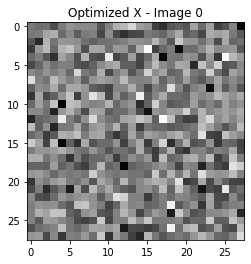

Displaying images from ./image folder:


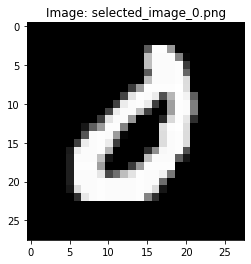

In [7]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import os
from PIL import Image

optimized_X_path = 'optimized_X.pth'
optimized_X = torch.load(optimized_X_path)

num_to_display = num_data_points 
for i in range(num_to_display):
    plt.imshow(optimized_X[i, 0].cpu().detach().numpy(), cmap='gray')
    plt.title(f"Optimized X - Image {i}")
    plt.show()

image_folder = './image'
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])

print("Displaying images from ./image folder:")
for image_file in image_files[:num_to_display]:
    img_path = os.path.join(image_folder, image_file)
    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image: {image_file}")
    plt.show()


In [6]:
X = torch.randn(num_data_points, 1, 28, 28, requires_grad=True, device=device)
y = torch.randint(0, 10, (num_data_points,), device=device)

optimizer = torch.optim.Adam([X], lr=0.01)

target_params = {name: param.detach() for name, param in target_model.named_parameters()}

num_epochs = 10
for epoch in range(num_epochs):
    idx = epoch % num_data_points
    
    fine_tuned_model = SimpleCNN().to(device)
    fine_tuned_model.load_state_dict(benign_model.state_dict())
    fine_tuned_model.train()

    fine_tune_optimizer = torch.optim.SGD(fine_tuned_model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1):
        running_loss = 0.0
        for i in range(len(selected_indices)):
            images = X[idx:idx + 1]
            labels = y[idx:idx + 1]

            fine_tune_optimizer.zero_grad()
            outputs = fine_tuned_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            fine_tune_optimizer.step()

            running_loss += loss.item()


    param_diff = sum(
        torch.norm(param - target_params[name])**2
        for name, param in fine_tuned_model.named_parameters()
    )

    optimizer.zero_grad()
    param_diff.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Total Loss: {param_diff.item():.4f}")

optimized_X = X.detach()
torch.save(optimized_X, 'optimized_X.pth')
print("Optimized training set X saved as 'optimized_X.pth'")

Epoch 1/10, Total Loss: 12.3218
Epoch 1/10, Total Loss: 12.3218
Epoch 1/10, Total Loss: 12.3218
Epoch 1/10, Total Loss: 12.3218
Epoch 1/10, Total Loss: 12.3218
Epoch 1/10, Total Loss: 12.3218
Epoch 1/10, Total Loss: 12.3218
Epoch 1/10, Total Loss: 12.3218
Epoch 1/10, Total Loss: 12.3218
Epoch 1/10, Total Loss: 12.3218
Optimized training set X saved as 'optimized_X.pth'
